In [126]:
import pandas as pd
import numpy as np
import os
import sys
from glob import glob
import matplotlib.pyplot as plt
from PIL import Image
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torch
import torchvision.transforms as transforms
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import classification_report, confusion_matrix
import json
from datetime import datetime
import random
import torch.nn.functional as F
from torch import nn, optim
from tqdm import tqdm

## Hierarchical Structure

In [127]:
# General path to data and other files needed
path = '/Users/ChamillaTerp/Dropbox/Skole/Master/Applied Machine Learning/AML2025_FinalProject/Chamilla/'

In [128]:
df = pd.read_csv(path + 'gz_decals_volunteers_5.csv')

In [129]:
level_0_labels = [
    'smooth-or-featured_smooth_debiased',
    'smooth-or-featured_featured-or-disk_debiased',
    'smooth-or-featured_artifact_debiased'
]

level_1_smooth_labels = [
    'how-rounded_round_debiased',
    'how-rounded_in-between_debiased',
    'how-rounded_cigar-shaped_debiased'
]

level_1_disk_labels = [
    'disk-edge-on_yes_debiased',
    'disk-edge-on_no_debiased',
    'bar_strong_debiased',
    'bar_weak_debiased',
    'bar_no_debiased',
    'has-spiral-arms_yes_debiased',
    'has-spiral-arms_no_debiased',
    'bulge-size_small_debiased',
    'bulge-size_moderate_debiased',
    'bulge-size_large_debiased',
    'bulge-size_dominant_debiased',
    'bulge-size_none_debiased'
]

level_2_spiral_labels = [
    'spiral-winding_tight_debiased',
    'spiral-winding_medium_debiased',
    'spiral-winding_loose_debiased',
    'spiral-arm-count_1_debiased',
    'spiral-arm-count_2_debiased',
    'spiral-arm-count_3_debiased',
    'spiral-arm-count_4_debiased',
    'spiral-arm-count_more-than-4_debiased',
    'spiral-arm-count_cant-tell_debiased'
]

final_labels = [
    'merging_none_debiased',
    'merging_minor-disturbance_debiased',
    'merging_major-disturbance_debiased',
    'merging_merger_debiased'
]


In [130]:
# Only using data where the relevant questions were answered
def filter_for_level_0(df):
    # Top-level questions must exist
    return df.dropna(subset = level_0_labels)

def filter_for_smooth_branch(df, min_votes = 10):
    return df[
        (df['smooth-or-featured_smooth_debiased'] >= 0.5) &
        (df['how-rounded_total-votes'] >= min_votes)
    ].dropna(subset = level_1_smooth_labels)

def filter_for_disk_branch(df, min_votes = 10):
    return df[
        (df['smooth-or-featured_featured-or-disk_debiased'] >= 0.5) &
        (df['bar_total-votes'] >= min_votes) &
        (df['disk-edge-on_total-votes'] >= min_votes) &
        (df['has-spiral-arms_total-votes'] >= min_votes) &
        (df['bulge-size_total-votes'] >= min_votes)
    ].dropna(subset = level_1_disk_labels)

def filter_for_spiral_branch(df, min_votes = 10):
    return df[
        (df['has-spiral-arms_yes_debiased'] >= 0.5) &
        (df['spiral-winding_total-votes'] >= min_votes) &
        (df['spiral-arm-count_total-votes'] >= min_votes)
    ].dropna(subset = level_2_spiral_labels)

def filter_for_merging(df, min_votes = 10):
    return df[
        (df['merging_total-votes'] >= min_votes)
    ].dropna(subset = final_labels)

In [131]:
# Filterig data
df = filter_for_level_0(df)
df_smooth = filter_for_smooth_branch(df)
df_disk = filter_for_disk_branch(df)
df_spiral = filter_for_spiral_branch(df_disk)
df_merging = filter_for_merging(df_spiral)

In [132]:
# Printing the number of galaxies/images for each branch
print(f"Total galaxies/images in dataset: {len(df)}")
print(f"Total galaxies/images in smooth branch: {len(df_smooth)}")
print(f"Total galaxies/images in disk branch: {len(df_disk)}")
print(f"Total galaxies/images in spiral branch: {len(df_spiral)}")
print(f"Total galaxies/images in merging branch: {len(df_merging)}")

Total galaxies/images in dataset: 59004
Total galaxies/images in smooth branch: 11749
Total galaxies/images in disk branch: 24119
Total galaxies/images in spiral branch: 16250
Total galaxies/images in merging branch: 16250


In [133]:
# Getting the image paths
path_images = path + 'gz_decals_dr5_png_part1'

# Step 1: Recursively collect all image file paths
all_image_paths = glob(os.path.join(path_images, '**', '*.png'), recursive = True)

# Step 2: Create a lookup dict: iauname -> full path
# Assumes filenames are like 'J123456.78+123456.7.png'
iauname_to_path = {
    os.path.splitext(os.path.basename(png_path))[0]: png_path
    for png_path in all_image_paths
}

# Step 3: Filter the DataFrame to only include rows with valid iauname
def filter_df_by_iauname(df, iauname_to_path):
    return df[df['iauname'].isin(iauname_to_path.keys())]

df = filter_df_by_iauname(df, iauname_to_path)
df_smooth = filter_df_by_iauname(df_smooth, iauname_to_path)
df_disk = filter_df_by_iauname(df_disk, iauname_to_path)
df_spiral = filter_df_by_iauname(df_spiral, iauname_to_path)
df_merging = filter_df_by_iauname(df_merging, iauname_to_path)

# Step 4: Create a new column with the full image path
def add_image_path_column(df, iauname_to_path):
    df['image_path'] = df['iauname'].map(iauname_to_path)
    return df

df = add_image_path_column(df, iauname_to_path)
df_smooth = add_image_path_column(df_smooth, iauname_to_path)
df_disk = add_image_path_column(df_disk, iauname_to_path)
df_spiral = add_image_path_column(df_spiral, iauname_to_path)
df_merging = add_image_path_column(df_merging, iauname_to_path)

# Step 5: Remove rows with NaN in 'image_path'
def remove_nan_image_paths(df):
    return df.dropna(subset = ['image_path'])

df = remove_nan_image_paths(df)
df_smooth = remove_nan_image_paths(df_smooth)
df_disk = remove_nan_image_paths(df_disk)
df_spiral = remove_nan_image_paths(df_spiral)
df_merging = remove_nan_image_paths(df_merging)

In [134]:
# Printing the number of galaxies/images for each cleaned branch
print(f"Total galaxies/images in dataset after filtering: {len(df)}")
print(f"Total galaxies/images in smooth branch after filtering: {len(df_smooth)}")
print(f"Total galaxies/images in disk branch after filtering: {len(df_disk)}")
print(f"Total galaxies/images in spiral branch after filtering: {len(df_spiral)}")
print(f"Total galaxies/images in merging branch after filtering: {len(df_merging)}")

Total galaxies/images in dataset after filtering: 18788
Total galaxies/images in smooth branch after filtering: 3681
Total galaxies/images in disk branch after filtering: 7970
Total galaxies/images in spiral branch after filtering: 5304
Total galaxies/images in merging branch after filtering: 5304


In [135]:
# Getting the data we want to use for training

# First; import the validation set 
path_val = '/Users/ChamillaTerp/Dropbox/Skole/Master/Applied Machine Learning/AML2025_FinalProject/validation_galaxies.csv'
df_val = pd.read_csv(path_val)

# Removing images from the datasets, that are present in the validation set - gives us the training set
def remove_validation_images(df, df_val):
    return df[~df['iauname'].isin(df_val['iauname'])]

df_level_0_training = remove_validation_images(df, df_val)
df_smooth_training = remove_validation_images(df_smooth, df_val)
df_disk_training = remove_validation_images(df_disk, df_val)
df_spiral_training = remove_validation_images(df_spiral, df_val)
df_merging_training = remove_validation_images(df_merging, df_val)

# Printing the number of galaxies/images in the training set
print(f"Total galaxies/images in dataset after removing validation set: {len(df_level_0_training)}")
print(f"Total galaxies/images in smooth branch after removing validation set: {len(df_smooth_training)}")
print(f"Total galaxies/images in disk branch after removing validation set: {len(df_disk_training)}")
print(f"Total galaxies/images in spiral branch after removing validation set: {len(df_spiral_training)}")
print(f"Total galaxies/images in merging branch after removing validation set: {len(df_merging_training)}")
print("")
print(f"Total number of galaxies/images in the validation set: {len(df_val)}")

Total galaxies/images in dataset after removing validation set: 15030
Total galaxies/images in smooth branch after removing validation set: 2915
Total galaxies/images in disk branch after removing validation set: 6403
Total galaxies/images in spiral branch after removing validation set: 4275
Total galaxies/images in merging branch after removing validation set: 4275

Total number of galaxies/images in the validation set: 3758


In [136]:
# Adding the image path to the validation set
def add_image_path_to_validation(df_val, iauname_to_path):
    df_val['image_path'] = df_val['iauname'].map(iauname_to_path)
    return df_val

df_val = add_image_path_to_validation(df_val, iauname_to_path)

# Making sure that the validation set has all of the labels we need (for all levels) for each image
def add_labels_to_validation(df_val, df):
    # Merging the validation set with the main dataset to get the labels
    df_val = df_val.merge(df[['iauname'] + level_0_labels + level_1_smooth_labels + level_1_disk_labels + level_2_spiral_labels + final_labels], on='iauname', how='left')
    return df_val

df_val = add_labels_to_validation(df_val, df)

# Printing the columns in the validation set
print("Columns in the validation set before adding labels:")
print(df_val.columns.tolist())

Columns in the validation set before adding labels:
['iauname', 'image_path', 'smooth-or-featured_smooth_debiased', 'smooth-or-featured_featured-or-disk_debiased', 'smooth-or-featured_artifact_debiased', 'how-rounded_round_debiased', 'how-rounded_in-between_debiased', 'how-rounded_cigar-shaped_debiased', 'disk-edge-on_yes_debiased', 'disk-edge-on_no_debiased', 'bar_strong_debiased', 'bar_weak_debiased', 'bar_no_debiased', 'has-spiral-arms_yes_debiased', 'has-spiral-arms_no_debiased', 'bulge-size_small_debiased', 'bulge-size_moderate_debiased', 'bulge-size_large_debiased', 'bulge-size_dominant_debiased', 'bulge-size_none_debiased', 'spiral-winding_tight_debiased', 'spiral-winding_medium_debiased', 'spiral-winding_loose_debiased', 'spiral-arm-count_1_debiased', 'spiral-arm-count_2_debiased', 'spiral-arm-count_3_debiased', 'spiral-arm-count_4_debiased', 'spiral-arm-count_more-than-4_debiased', 'spiral-arm-count_cant-tell_debiased', 'merging_none_debiased', 'merging_minor-disturbance_debia

In [137]:
# Checking if there is a overlap in the validation set and the training set
def check_overlap(df_training, df_val):
    overlap = df_training[df_training['iauname'].isin(df_val['iauname'])]
    return len(overlap)

overlap_level_0 = check_overlap(df_level_0_training, df_val)
overlap_smooth = check_overlap(df_smooth_training, df_val)
overlap_disk = check_overlap(df_disk_training, df_val)
overlap_spiral = check_overlap(df_spiral_training, df_val)
overlap_merging = check_overlap(df_merging_training, df_val)

print(f"Overlap in level 0 training set and validation set: {overlap_level_0}")
print(f"Overlap in smooth training set and validation set: {overlap_smooth}")
print(f"Overlap in disk training set and validation set: {overlap_disk}")
print(f"Overlap in spiral training set and validation set: {overlap_spiral}")
print(f"Overlap in merging training set and validation set: {overlap_merging}")

Overlap in level 0 training set and validation set: 0
Overlap in smooth training set and validation set: 0
Overlap in disk training set and validation set: 0
Overlap in spiral training set and validation set: 0
Overlap in merging training set and validation set: 0


In [138]:
# Making sure we have a path to the directory where all .py files are located
path = '/Users/ChamillaTerp/Dropbox/Skole/Master/Applied Machine Learning/AML2025_FinalProject/Chamilla'
sys.path.append(path)

In [139]:
import GalaxyBranchDataset

In [140]:
# Making the datasets
dataset = GalaxyBranchDataset.GalaxyBranchDataset(df, level_0_labels, image_col = 'image_path')
dataset_smooth = GalaxyBranchDataset.GalaxyBranchDataset(df_smooth, level_1_smooth_labels, image_col = 'image_path')
dataset_disk = GalaxyBranchDataset.GalaxyBranchDataset(df_disk, level_1_disk_labels, image_col = 'image_path')
dataset_spiral = GalaxyBranchDataset.GalaxyBranchDataset(df_spiral, level_2_spiral_labels, image_col = 'image_path')
dataset_merging = GalaxyBranchDataset.GalaxyBranchDataset(df_merging, final_labels, image_col = 'image_path')

In [141]:
# Wrapping the datasets in DataLoaders
def create_dataloader(dataset, batch_size = 32, shuffle = True):
    return DataLoader(dataset, batch_size = batch_size, shuffle = shuffle)

dataloader_level_0 = create_dataloader(dataset)
dataloader_smooth = create_dataloader(dataset_smooth)
dataloader_disk = create_dataloader(dataset_disk)
dataloader_spiral = create_dataloader(dataset_spiral)
dataloader_merging = create_dataloader(dataset_merging)

### Making models

In [143]:
# Defining a simple CNN
class SimpleCNN(nn.Module):
    def __init__(self, num_outputs = 10):                                       # Initialize the CNN with a specified number of output classes (default is 8)

        super(SimpleCNN, self).__init__()                                       # Initialize the parent class 

        self.conv1 = nn.Conv2d(3, 16, kernel_size = 3, padding = 1)             # First convolutional layer with 3 input channels (RGB), 16 output channels, and a kernel size of 3
        self.conv2 = nn.Conv2d(16, 32, kernel_size = 3, padding = 1)            # Second convolutional layer with 16 input channels and 32 output channels
        self.conv3 = nn.Conv2d(32, 64, kernel_size = 3, padding = 1)            # Third convolutional layer with 32 input channels and 64 output channels

        self.pool = nn.MaxPool2d(kernel_size = 2, stride = 2)                   # Max pooling layer to reduce spatial dimensions 
        self.dropout = nn.Dropout(0.5)                                          # Dropout layer to prevent overfitting - randomly sets 50% of the input units to 0 during training

        self.fc1 = nn.Linear(64 * 28 * 28, 256)                                 # Fully connected layer with input size based on the output of the last convolutional layer and 256 output units
        self.fc2 = nn.Linear(256, num_outputs)                                  # Second fully connected layer with 256 input units and output size equal to the number of labels

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))                                    # Apply first convolution, ReLU activation, and max pooling
        x = self.pool(F.relu(self.conv2(x)))                                    # Apply second convolution, ReLU activation, and max pooling
        x = self.pool(F.relu(self.conv3(x)))                                    # Apply third convolution, ReLU activation, and max pooling

        x = x.view(x.size(0), -1)                                                # Flatten the tensor for the fully connected layers
        x = F.relu(self.fc1(x))                                                  # Apply first fully connected layer with ReLU activation
        x = self.dropout(x)                                                      # Apply dropout
        x = self.fc2(x)                                                          # Apply second fully connected layer

        return x                                                                 # Return the output logits

In [144]:
def train_model(model, train_loader, val_loader, num_epochs=10, lr=1e-4, device='cpu'):
    model = model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()

    train_losses = []
    val_losses = []

    for epoch in range(num_epochs):
        model.train()
        running_train_loss = 0.0

        for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_train_loss += loss.item() * images.size(0)

        epoch_train_loss = running_train_loss / len(train_loader.dataset)
        train_losses.append(epoch_train_loss)

        # Validation loop (always runs now)
        model.eval()
        running_val_loss = 0.0
        with torch.no_grad():
            for val_images, val_labels in val_loader:
                val_images, val_labels = val_images.to(device), val_labels.to(device)
                val_outputs = model(val_images)
                val_loss = criterion(val_outputs, val_labels)
                running_val_loss += val_loss.item() * val_images.size(0)

        epoch_val_loss = running_val_loss / len(val_loader.dataset)
        val_losses.append(epoch_val_loss)

        print(f"Epoch {epoch+1}: Train Loss = {epoch_train_loss:.4f} | Val Loss = {epoch_val_loss:.4f}")

    return model, train_losses, val_losses

In [149]:
def compute_accuracy(logits, labels):
    preds = torch.argmax(logits, dim=1)
    correct = (preds == labels).sum().item()
    return correct / labels.size(0)

def train_model(model, train_loader, val_loader, num_epochs=10, lr=1e-4, device='cpu'):
    model = model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()

    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    for epoch in range(num_epochs):
        model.train()
        running_train_loss = 0.0
        correct_train = 0
        total_train = 0

        for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
            images, labels = images.to(device), labels.to(device)
            if labels.ndim > 1:  # one-hot → class index
                labels = labels.argmax(dim=1)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_train_loss += loss.item() * images.size(0)
            correct_train += (outputs.argmax(dim=1) == labels).sum().item()
            total_train += labels.size(0)

        epoch_train_loss = running_train_loss / total_train
        epoch_train_acc = correct_train / total_train
        train_losses.append(epoch_train_loss)
        train_accuracies.append(epoch_train_acc)

        # Validation
        model.eval()
        running_val_loss = 0.0
        correct_val = 0
        total_val = 0
        with torch.no_grad():
            for val_images, val_labels in val_loader:
                val_images, val_labels = val_images.to(device), val_labels.to(device)

                # Convert one-hot encoded labels to class indices if needed
                if val_labels.ndim > 1:
                    val_labels = val_labels.argmax(dim=1)

                val_outputs = model(val_images)
                val_loss = criterion(val_outputs, val_labels)

                running_val_loss += val_loss.item() * val_images.size(0)
                correct_val += (val_outputs.argmax(dim=1) == val_labels).sum().item()
                total_val += val_labels.size(0)

        epoch_val_loss = running_val_loss / total_val
        epoch_val_acc = correct_val / total_val
        val_losses.append(epoch_val_loss)
        val_accuracies.append(epoch_val_acc)

        print(f"Epoch {epoch+1}: Train Loss = {epoch_train_loss:.4f}, Train Acc = {epoch_train_acc:.4f} | Val Loss = {epoch_val_loss:.4f}, Val Acc = {epoch_val_acc:.4f}")

    # Return all metrics
    metrics = {
        'train_losses': train_losses,
        'val_losses': val_losses,
        'train_accuracies': train_accuracies,
        'val_accuracies': val_accuracies
    }

    return model, metrics


In [150]:
# Making the models
model_level_0 = SimpleCNN(num_outputs = len(level_0_labels))
model_smooth = SimpleCNN(num_outputs = len(level_1_smooth_labels))
model_disk = SimpleCNN(num_outputs = len(level_1_disk_labels))
model_spiral = SimpleCNN(num_outputs = len(level_2_spiral_labels))
model_merging = SimpleCNN(num_outputs = len(final_labels))

In [151]:
# Preparing the validation set for level 0
val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5]),
])

val_level_0 = GalaxyBranchDataset.GalaxyBranchDataset(df_val, level_0_labels, transform = val_transform, image_col = 'image_path')
dataloader_val_level_0 = create_dataloader(val_level_0, batch_size = 32, shuffle = False)

### ---- LEVEL 0 ----

In [152]:
device = 'cpu'
num_epochs = 21

model_level_0, metrics_level_0 = train_model(
    model_level_0,
    dataloader_level_0,
    dataloader_val_level_0,
    num_epochs=num_epochs,
    lr=1e-4,
    device=device
)

# Extract individual components if needed
train_losses_level_0 = metrics_level_0['train_losses']
val_losses_level_0 = metrics_level_0['val_losses']
train_accuracies_level_0 = metrics_level_0['train_accuracies']
val_accuracies_level_0 = metrics_level_0['val_accuracies']

Epoch 1/21: 100%|██████████| 588/588 [05:16<00:00,  1.86it/s]


Epoch 1: Train Loss = 0.5599, Train Acc = 0.7833 | Val Loss = 0.5406, Val Acc = 0.7789


Epoch 2/21: 100%|██████████| 588/588 [05:08<00:00,  1.90it/s]


Epoch 2: Train Loss = 0.5360, Train Acc = 0.7882 | Val Loss = 0.5223, Val Acc = 0.7898


Epoch 3/21: 100%|██████████| 588/588 [05:06<00:00,  1.92it/s]


Epoch 3: Train Loss = 0.5246, Train Acc = 0.7909 | Val Loss = 0.5100, Val Acc = 0.7908


Epoch 4/21: 100%|██████████| 588/588 [04:48<00:00,  2.04it/s]


Epoch 4: Train Loss = 0.5161, Train Acc = 0.7941 | Val Loss = 0.4948, Val Acc = 0.7903


Epoch 5/21: 100%|██████████| 588/588 [04:57<00:00,  1.98it/s]


Epoch 5: Train Loss = 0.5062, Train Acc = 0.7964 | Val Loss = 0.4829, Val Acc = 0.7999


Epoch 6/21: 100%|██████████| 588/588 [05:05<00:00,  1.92it/s]


Epoch 6: Train Loss = 0.4998, Train Acc = 0.7980 | Val Loss = 0.4799, Val Acc = 0.8020


Epoch 7/21: 100%|██████████| 588/588 [05:11<00:00,  1.89it/s]


Epoch 7: Train Loss = 0.4893, Train Acc = 0.8004 | Val Loss = 0.4725, Val Acc = 0.8031


Epoch 8/21: 100%|██████████| 588/588 [05:08<00:00,  1.90it/s]


Epoch 8: Train Loss = 0.4889, Train Acc = 0.8027 | Val Loss = 0.4738, Val Acc = 0.8012


Epoch 9/21: 100%|██████████| 588/588 [05:04<00:00,  1.93it/s]


Epoch 9: Train Loss = 0.4845, Train Acc = 0.7998 | Val Loss = 0.4719, Val Acc = 0.8018


Epoch 10/21: 100%|██████████| 588/588 [05:10<00:00,  1.89it/s]


Epoch 10: Train Loss = 0.4844, Train Acc = 0.8016 | Val Loss = 0.4656, Val Acc = 0.8012


Epoch 11/21: 100%|██████████| 588/588 [05:09<00:00,  1.90it/s]


Epoch 11: Train Loss = 0.4789, Train Acc = 0.8026 | Val Loss = 0.4625, Val Acc = 0.8049


Epoch 12/21: 100%|██████████| 588/588 [05:03<00:00,  1.94it/s]


Epoch 12: Train Loss = 0.4735, Train Acc = 0.8019 | Val Loss = 0.4613, Val Acc = 0.8034


Epoch 13/21: 100%|██████████| 588/588 [05:10<00:00,  1.89it/s]


Epoch 13: Train Loss = 0.4689, Train Acc = 0.8065 | Val Loss = 0.4569, Val Acc = 0.8076


Epoch 14/21: 100%|██████████| 588/588 [05:57<00:00,  1.65it/s]


Epoch 14: Train Loss = 0.4713, Train Acc = 0.8066 | Val Loss = 0.4632, Val Acc = 0.8057


Epoch 15/21: 100%|██████████| 588/588 [19:28<00:00,  1.99s/it]   


Epoch 15: Train Loss = 0.4657, Train Acc = 0.8050 | Val Loss = 0.4534, Val Acc = 0.8060


Epoch 16/21: 100%|██████████| 588/588 [05:02<00:00,  1.94it/s]


Epoch 16: Train Loss = 0.4664, Train Acc = 0.8046 | Val Loss = 0.4465, Val Acc = 0.8097


Epoch 17/21: 100%|██████████| 588/588 [05:08<00:00,  1.91it/s]


Epoch 17: Train Loss = 0.4612, Train Acc = 0.8055 | Val Loss = 0.4489, Val Acc = 0.8047


Epoch 18/21: 100%|██████████| 588/588 [05:00<00:00,  1.96it/s]


Epoch 18: Train Loss = 0.4582, Train Acc = 0.8072 | Val Loss = 0.4479, Val Acc = 0.8073


Epoch 19/21: 100%|██████████| 588/588 [04:56<00:00,  1.98it/s]


Epoch 19: Train Loss = 0.4574, Train Acc = 0.8075 | Val Loss = 0.4447, Val Acc = 0.8095


Epoch 20/21: 100%|██████████| 588/588 [05:01<00:00,  1.95it/s]


Epoch 20: Train Loss = 0.4561, Train Acc = 0.8105 | Val Loss = 0.4472, Val Acc = 0.8052


Epoch 21/21: 100%|██████████| 588/588 [04:59<00:00,  1.96it/s]


Epoch 21: Train Loss = 0.4536, Train Acc = 0.8079 | Val Loss = 0.4404, Val Acc = 0.8063


### Evaluation model

In [155]:
def evaluate_multiclass_model(model, dataloader, label_names=None, device='cpu'):
    model.eval()
    model.to(device)

    all_probs = []
    all_preds = []
    all_targets = []

    with torch.no_grad():
        for images, labels in dataloader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)  # raw logits
            probs = torch.softmax(outputs, dim=1).cpu()
            preds = torch.argmax(probs, dim=1)

            labels = labels.cpu()
            if labels.ndim > 1:  # handle one-hot labels
                labels = labels.argmax(dim=1)

            all_probs.extend(probs.numpy())
            all_preds.extend(preds.numpy())
            all_targets.extend(labels.numpy())

    print("Classification Report:")
    print(classification_report(
        all_targets,
        all_preds,
        labels=list(range(len(label_names))),
        target_names=label_names
    ))
    print("Confusion Matrix:")
    print(confusion_matrix(all_targets, all_preds))

    return np.array(all_probs), np.array(all_preds), np.array(all_targets)


In [156]:
# Evaluating the level 0 model
probs_level_0, preds_level_0, targets_level_0 = evaluate_multiclass_model(
    model_level_0,
    dataloader_val_level_0,
    label_names = level_0_labels,
    device = device
)

Classification Report:
                                              precision    recall  f1-score   support

          smooth-or-featured_smooth_debiased       0.63      0.32      0.42       803
smooth-or-featured_featured-or-disk_debiased       0.83      0.95      0.88      2921
        smooth-or-featured_artifact_debiased       0.00      0.00      0.00        34

                                    accuracy                           0.81      3758
                                   macro avg       0.49      0.42      0.44      3758
                                weighted avg       0.78      0.81      0.78      3758

Confusion Matrix:
[[ 255  548    0]
 [ 146 2775    0]
 [   5   29    0]]


/Applications/anaconda3/envs/MachineLearning/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Applications/anaconda3/envs/MachineLearning/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Applications/anaconda3/envs/MachineLearning/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

In [157]:
def print_confident_galaxies_per_true_label(df_val, probs, targets, class_names, conf_threshold=0.2):
    for class_id, class_name in enumerate(class_names):
        true_mask = (targets == class_id)
        if true_mask.sum() == 0:
            print(f"No samples with true label '{class_name}' found.")
            continue

        true_indices = np.where(true_mask)[0]
        true_probs = probs[true_mask, class_id]

        # Filter by confidence threshold
        high_conf_mask = true_probs > conf_threshold
        if not np.any(high_conf_mask):
            print(f"No samples with confidence > {conf_threshold} for class '{class_name}'.")
            continue

        high_conf_indices = true_indices[high_conf_mask]
        high_conf_probs = true_probs[high_conf_mask]

        # Pick the highest confidence galaxy
        best_idx_in_true = np.argmax(high_conf_probs)
        best_idx = high_conf_indices[best_idx_in_true]
        galaxy_name = df_val.iloc[best_idx]["iauname"]
        confidence = high_conf_probs[best_idx_in_true]

        print(f"Class '{class_name}':")
        print(f"  Galaxy: {galaxy_name}, Confidence: {confidence:.4f}")
        print("")

In [158]:
print_confident_galaxies_per_true_label(
    df_val = df_val,
    probs = probs_level_0,
    targets = targets_level_0,
    class_names = level_0_labels,
    conf_threshold = 0.2
)

Class 'smooth-or-featured_smooth_debiased':
  Galaxy: J020400.01-090621.4, Confidence: 0.7997

Class 'smooth-or-featured_featured-or-disk_debiased':
  Galaxy: J022958.33-003414.1, Confidence: 0.9925

Class 'smooth-or-featured_artifact_debiased':
  Galaxy: J004636.39+201521.9, Confidence: 0.3044



Image size: (424, 424), Type: <class 'PIL.PngImagePlugin.PngImageFile'>


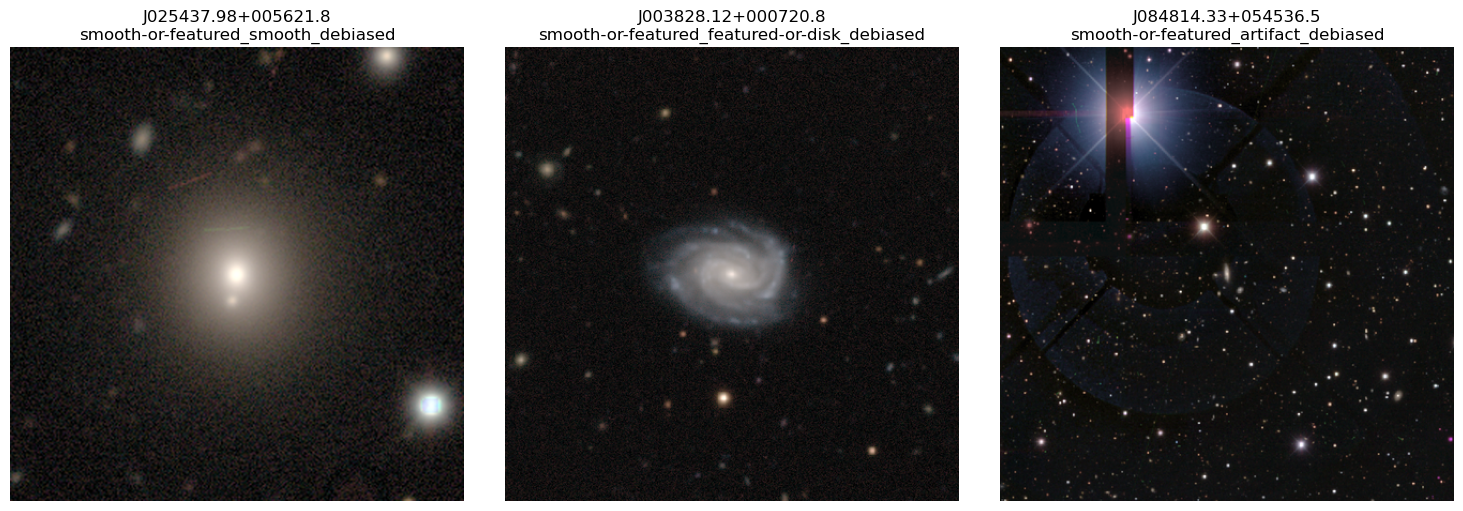

In [159]:
names = ['J025437.98+005621.8', 'J003828.12+000720.8', 'J084814.33+054536.5']
class_of_names = ['smooth-or-featured_smooth_debiased', 'smooth-or-featured_featured-or-disk_debiased', 'smooth-or-featured_artifact_debiased']

# Getting the images for the three objects
def get_image_by_name(df_val, name):
    image_path = df_val[df_val['iauname'] == name]['image_path'].values[0]
    return Image.open(image_path)

# Checking the dimensions and type of the images
def check_image_dimensions_and_type(image):
    print(f"Image size: {image.size}, Type: {type(image)}")

check_image_dimensions_and_type(get_image_by_name(df_val, names[0]))

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for ax, name, class_name in zip(axes, names, class_of_names):
    galaxy_df = df_val[df_val['iauname'] == name]
    if galaxy_df.empty:
        print(f"No data found for galaxy {name}")
        ax.axis('off')
        continue

    image_path = galaxy_df['image_path'].values[0]
    img = Image.open(image_path).convert('RGB')

    ax.imshow(img)
    ax.set_title(f"{name}\n{class_name}", fontsize=12)
    ax.axis('off')

plt.tight_layout()
plt.show()

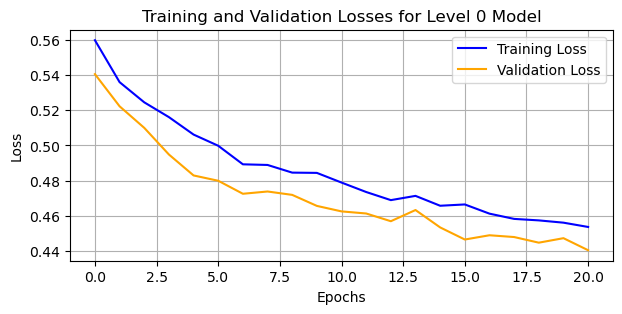

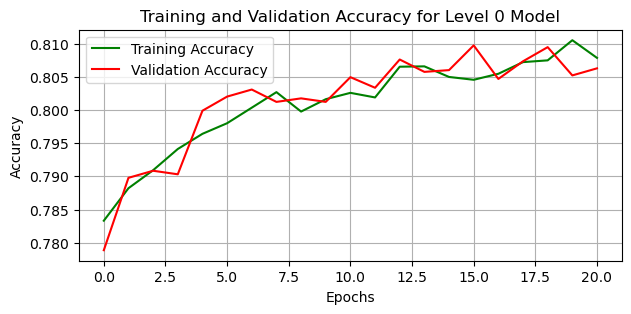

In [163]:
# Plotting the training and validation losses for level 0
def plot_losses(train_losses, val_losses, title = 'Training and Validation Losses'):
    plt.figure(figsize = (7, 3))
    plt.plot(train_losses, label = 'Training Loss', color = 'blue')
    plt.plot(val_losses, label = 'Validation Loss', color = 'orange')
    plt.title(title)
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid()
    plt.show()

def plot_accuracies(train_accuracies, val_accuracies, title='Training and Validation Accuracy'):
    plt.figure(figsize=(7, 3))
    plt.plot(train_accuracies, label='Training Accuracy', color='green')
    plt.plot(val_accuracies, label='Validation Accuracy', color='red')
    plt.title(title)
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid()
    plt.show()

plot_losses(train_losses_level_0, val_losses_level_0, title = 'Training and Validation Losses for Level 0 Model')
plot_accuracies(train_accuracies_level_0, val_accuracies_level_0, title = 'Training and Validation Accuracy for Level 0 Model')

### ---- LEVEL 1 ----

In [165]:
val_level_1_smooth = GalaxyBranchDataset.GalaxyBranchDataset(
    df_val, level_1_smooth_labels, transform = val_transform, image_col = 'image_path'
)
dataloader_val_smooth = create_dataloader(val_level_1_smooth, batch_size = 32, shuffle = False)

val_level_1_disk = GalaxyBranchDataset.GalaxyBranchDataset(
    df_val, level_1_disk_labels, transform = val_transform, image_col = 'image_path'
)
dataloader_val_disk = create_dataloader(val_level_1_disk, batch_size = 32, shuffle = False)

In [166]:
device = 'cpu'
num_epochs = 10

# Train smooth branch
model_smooth, metrics_smooth = train_model(
    model_smooth,
    dataloader_smooth,
    dataloader_val_smooth,
    num_epochs=num_epochs,
    lr = 1e-4,
    device = device
)

train_losses_smooth = metrics_smooth['train_losses']
val_losses_smooth = metrics_smooth['val_losses']
train_accuracies_smooth = metrics_smooth['train_accuracies']
val_accuracies_smooth = metrics_smooth['val_accuracies']

Epoch 1/10: 100%|██████████| 116/116 [01:01<00:00,  1.89it/s]


Epoch 1: Train Loss = 0.9276, Train Acc = 0.4811 | Val Loss = 1.1569, Val Acc = 0.4470


Epoch 2/10: 100%|██████████| 116/116 [00:59<00:00,  1.94it/s]


Epoch 2: Train Loss = 0.9117, Train Acc = 0.5023 | Val Loss = 1.0846, Val Acc = 0.4465


Epoch 3/10: 100%|██████████| 116/116 [00:58<00:00,  1.97it/s]


Epoch 3: Train Loss = 0.8999, Train Acc = 0.5001 | Val Loss = 1.1961, Val Acc = 0.4470


Epoch 4/10: 100%|██████████| 116/116 [00:58<00:00,  1.99it/s]


Epoch 4: Train Loss = 0.8970, Train Acc = 0.5126 | Val Loss = 1.0660, Val Acc = 0.4470


Epoch 5/10: 100%|██████████| 116/116 [00:58<00:00,  1.98it/s]


Epoch 5: Train Loss = 0.8938, Train Acc = 0.5072 | Val Loss = 1.1224, Val Acc = 0.4470


Epoch 6/10: 100%|██████████| 116/116 [00:58<00:00,  1.98it/s]


Epoch 6: Train Loss = 0.8920, Train Acc = 0.4990 | Val Loss = 1.0961, Val Acc = 0.4529


Epoch 7/10: 100%|██████████| 116/116 [01:00<00:00,  1.93it/s]


Epoch 7: Train Loss = 0.8741, Train Acc = 0.5162 | Val Loss = 1.1421, Val Acc = 0.4553


Epoch 8/10: 100%|██████████| 116/116 [00:58<00:00,  1.98it/s]


Epoch 8: Train Loss = 0.8757, Train Acc = 0.5096 | Val Loss = 1.0399, Val Acc = 0.4518


Epoch 9/10: 100%|██████████| 116/116 [00:58<00:00,  2.00it/s]


Epoch 9: Train Loss = 0.8699, Train Acc = 0.5173 | Val Loss = 1.1420, Val Acc = 0.4572


Epoch 10/10: 100%|██████████| 116/116 [00:58<00:00,  1.99it/s]


Epoch 10: Train Loss = 0.8683, Train Acc = 0.5230 | Val Loss = 1.0543, Val Acc = 0.4574


In [167]:
# Train disk branch
model_disk, metrics_disk = train_model(
    model_disk,
    dataloader_disk,
    dataloader_val_disk,
    num_epochs=num_epochs,
    lr = 1e-4,
    device = device
)

train_losses_disk = metrics_disk['train_losses']
val_losses_disk = metrics_disk['val_losses']
train_accuracies_disk = metrics_disk['train_accuracies']
val_accuracies_disk = metrics_disk['val_accuracies']

Epoch 1/10: 100%|██████████| 250/250 [02:09<00:00,  1.93it/s]


Epoch 1: Train Loss = 0.9971, Train Acc = 0.6248 | Val Loss = 1.7260, Val Acc = 0.5114


Epoch 2/10: 100%|██████████| 250/250 [02:03<00:00,  2.02it/s]


Epoch 2: Train Loss = 0.9471, Train Acc = 0.6402 | Val Loss = 1.8173, Val Acc = 0.5114


Epoch 3/10: 100%|██████████| 250/250 [02:06<00:00,  1.98it/s]


Epoch 3: Train Loss = 0.9419, Train Acc = 0.6415 | Val Loss = 1.8904, Val Acc = 0.5114


Epoch 4/10: 100%|██████████| 250/250 [02:04<00:00,  2.01it/s]


Epoch 4: Train Loss = 0.9390, Train Acc = 0.6415 | Val Loss = 1.7901, Val Acc = 0.5114


Epoch 5/10: 100%|██████████| 250/250 [02:03<00:00,  2.03it/s]


Epoch 5: Train Loss = 0.9342, Train Acc = 0.6417 | Val Loss = 1.7364, Val Acc = 0.5114


Epoch 6/10: 100%|██████████| 250/250 [02:03<00:00,  2.02it/s]


Epoch 6: Train Loss = 0.9320, Train Acc = 0.6417 | Val Loss = 1.8223, Val Acc = 0.5114


Epoch 7/10: 100%|██████████| 250/250 [02:03<00:00,  2.02it/s]


Epoch 7: Train Loss = 0.9282, Train Acc = 0.6417 | Val Loss = 1.9143, Val Acc = 0.5114


Epoch 8/10: 100%|██████████| 250/250 [02:06<00:00,  1.98it/s]


Epoch 8: Train Loss = 0.9267, Train Acc = 0.6417 | Val Loss = 1.7511, Val Acc = 0.5114


Epoch 9/10: 100%|██████████| 250/250 [02:06<00:00,  1.98it/s]


Epoch 9: Train Loss = 0.9260, Train Acc = 0.6417 | Val Loss = 1.7762, Val Acc = 0.5114


Epoch 10/10: 100%|██████████| 250/250 [02:05<00:00,  1.99it/s]


Epoch 10: Train Loss = 0.9264, Train Acc = 0.6417 | Val Loss = 1.7811, Val Acc = 0.5114


In [168]:
probs_smooth, preds_smooth, targets_smooth = evaluate_multiclass_model(
    model_smooth,
    dataloader_val_smooth,
    label_names = level_1_smooth_labels,
    device = device
)

probs_disk, preds_disk, targets_disk = evaluate_multiclass_model(
    model_disk,
    dataloader_val_disk,
    label_names = level_1_disk_labels,
    device = device
)

Classification Report:
                                   precision    recall  f1-score   support

       how-rounded_round_debiased       0.51      0.25      0.33      1269
  how-rounded_in-between_debiased       0.45      0.84      0.58      1680
how-rounded_cigar-shaped_debiased       0.00      0.00      0.00       809

                         accuracy                           0.46      3758
                        macro avg       0.32      0.36      0.31      3758
                     weighted avg       0.37      0.46      0.37      3758

Confusion Matrix:
[[ 312  957    0]
 [ 273 1407    0]
 [  23  786    0]]


/Applications/anaconda3/envs/MachineLearning/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Applications/anaconda3/envs/MachineLearning/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Applications/anaconda3/envs/MachineLearning/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

Classification Report:
                              precision    recall  f1-score   support

   disk-edge-on_yes_debiased       0.00      0.00      0.00       193
    disk-edge-on_no_debiased       0.51      1.00      0.68      1922
         bar_strong_debiased       0.00      0.00      0.00        33
           bar_weak_debiased       0.00      0.00      0.00        34
             bar_no_debiased       0.00      0.00      0.00       660
has-spiral-arms_yes_debiased       0.00      0.00      0.00       650
 has-spiral-arms_no_debiased       0.00      0.00      0.00       219
   bulge-size_small_debiased       0.00      0.00      0.00        25
bulge-size_moderate_debiased       0.00      0.00      0.00        15
   bulge-size_large_debiased       0.00      0.00      0.00         1
bulge-size_dominant_debiased       0.00      0.00      0.00         0
    bulge-size_none_debiased       0.00      0.00      0.00         6

                    accuracy                           0.51      

/Applications/anaconda3/envs/MachineLearning/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Applications/anaconda3/envs/MachineLearning/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Applications/anaconda3/envs/MachineLearning/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, 

In [169]:
# Printing confident galaxies for level 1 smooth branch
print_confident_galaxies_per_true_label(
    df_val = df_val,
    probs = probs_smooth,
    targets = targets_smooth,
    class_names = level_1_smooth_labels,
    conf_threshold = 0.1
)

print('')

# Printing confident galaxies for level 1 disk branch
print_confident_galaxies_per_true_label(
    df_val = df_val,
    probs = probs_disk,
    targets = targets_disk,
    class_names = level_1_disk_labels,
    conf_threshold = 0.1
)

Class 'how-rounded_round_debiased':
  Galaxy: J023838.79+040244.0, Confidence: 0.5542

Class 'how-rounded_in-between_debiased':
  Galaxy: J083234.68+042408.1, Confidence: 0.5069

Class 'how-rounded_cigar-shaped_debiased':
  Galaxy: J084329.16+060754.7, Confidence: 0.2299


No samples with confidence > 0.1 for class 'disk-edge-on_yes_debiased'.
Class 'disk-edge-on_no_debiased':
  Galaxy: J090312.25+224147.2, Confidence: 0.6528

No samples with confidence > 0.1 for class 'bar_strong_debiased'.
No samples with confidence > 0.1 for class 'bar_weak_debiased'.
No samples with confidence > 0.1 for class 'bar_no_debiased'.
Class 'has-spiral-arms_yes_debiased':
  Galaxy: J024603.40-082605.7, Confidence: 0.3173

No samples with confidence > 0.1 for class 'has-spiral-arms_no_debiased'.
No samples with confidence > 0.1 for class 'bulge-size_small_debiased'.
No samples with confidence > 0.1 for class 'bulge-size_moderate_debiased'.
No samples with confidence > 0.1 for class 'bulge-size_large_debias

Image size: (424, 424), Type: <class 'PIL.PngImagePlugin.PngImageFile'>


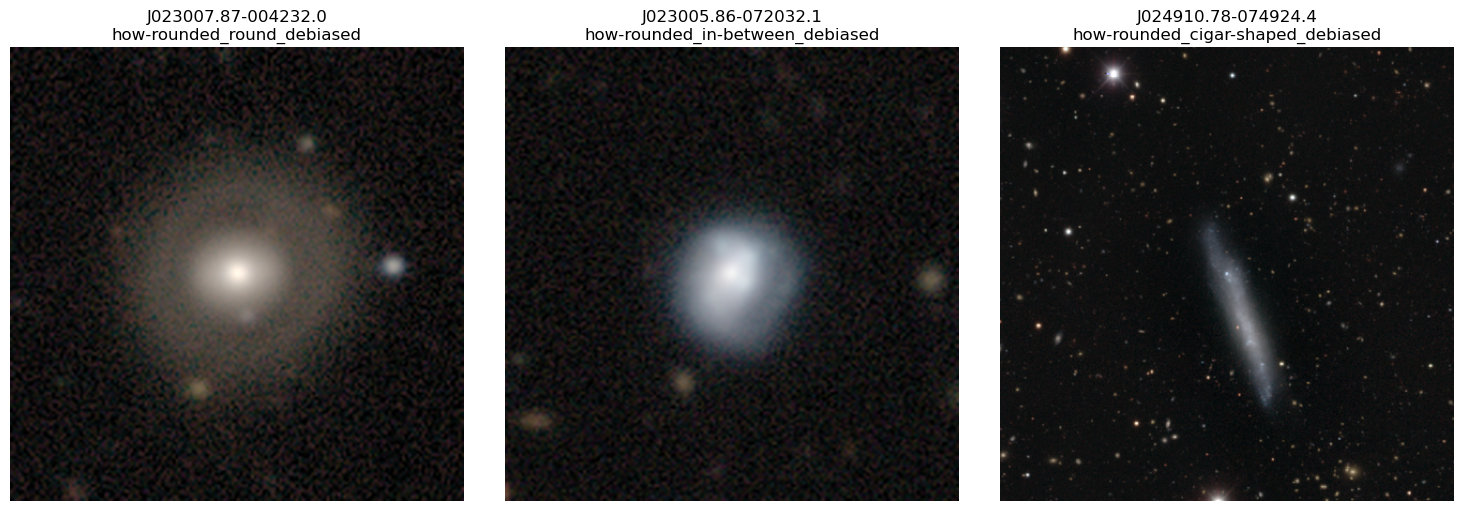

In [170]:
names = ['J023007.87-004232.0', 'J023005.86-072032.1', 'J024910.78-074924.4']
class_of_names = ['how-rounded_round_debiased', 'how-rounded_in-between_debiased', 'how-rounded_cigar-shaped_debiased']

# Getting the images for the three objects
def get_image_by_name(df_val, name):
    image_path = df_val[df_val['iauname'] == name]['image_path'].values[0]
    return Image.open(image_path)

# Checking the dimensions and type of the images
def check_image_dimensions_and_type(image):
    print(f"Image size: {image.size}, Type: {type(image)}")

check_image_dimensions_and_type(get_image_by_name(df_val, names[0]))

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for ax, name, class_name in zip(axes, names, class_of_names):
    galaxy_df = df_val[df_val['iauname'] == name]
    if galaxy_df.empty:
        print(f"No data found for galaxy {name}")
        ax.axis('off')
        continue

    image_path = galaxy_df['image_path'].values[0]
    img = Image.open(image_path).convert('RGB')

    ax.imshow(img)
    ax.set_title(f"{name}\n{class_name}", fontsize=12)
    ax.axis('off')

plt.tight_layout()
plt.show()

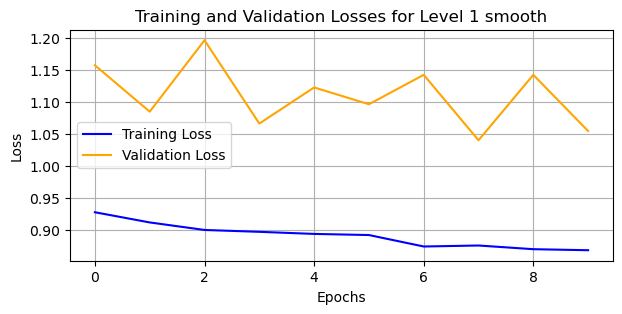

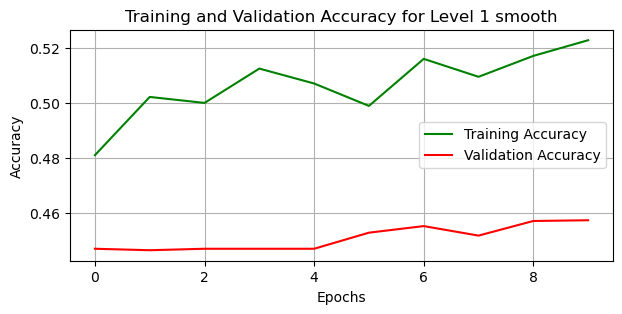

In [171]:
plot_losses(train_losses_smooth, val_losses_smooth, title = 'Training and Validation Losses for Level 1 smooth')
plot_accuracies(train_accuracies_smooth, val_accuracies_smooth, title = 'Training and Validation Accuracy for Level 1 smooth')

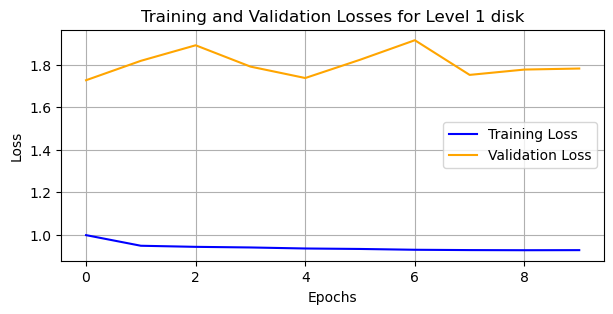

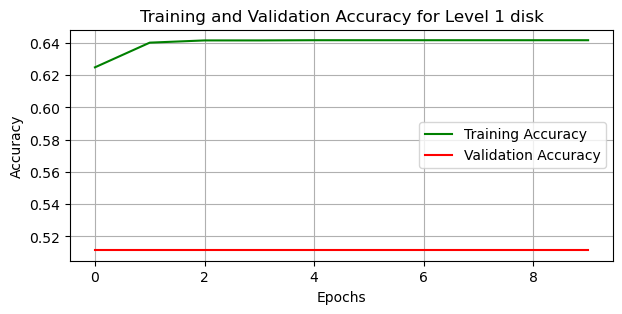

In [172]:
plot_losses(train_losses_disk, val_losses_disk, title = 'Training and Validation Losses for Level 1 disk')
plot_accuracies(train_accuracies_disk, val_accuracies_disk, title = 'Training and Validation Accuracy for Level 1 disk')

### ---- LEVEL 2 ----

In [173]:
val_level_2_spiral = GalaxyBranchDataset.GalaxyBranchDataset(
    df_val, level_2_spiral_labels, transform = val_transform, image_col = 'image_path'
)
dataloader_val_spiral = create_dataloader(val_level_2_spiral, batch_size = 32, shuffle = False)

In [174]:
num_epochs = 10
device = 'cpu'

# Train spiral branch
model_spiral, metrics_spiral = train_model(
    model_spiral,
    dataloader_spiral,
    dataloader_val_spiral,
    num_epochs = num_epochs,
    lr = 1e-4,
    device = device
)

train_losses_spiral = metrics_spiral['train_losses']
val_losses_spiral = metrics_spiral['val_losses']
train_accuracies_spiral = metrics_spiral['train_accuracies']
val_accuracies_spiral = metrics_spiral['val_accuracies']

Epoch 1/10: 100%|██████████| 166/166 [01:25<00:00,  1.94it/s]


Epoch 1: Train Loss = 1.3176, Train Acc = 0.5613 | Val Loss = 1.1605, Val Acc = 0.7185


Epoch 2/10: 100%|██████████| 166/166 [01:24<00:00,  1.97it/s]


Epoch 2: Train Loss = 1.2754, Train Acc = 0.5733 | Val Loss = 1.1710, Val Acc = 0.7185


Epoch 3/10: 100%|██████████| 166/166 [01:23<00:00,  1.99it/s]


Epoch 3: Train Loss = 1.2643, Train Acc = 0.5752 | Val Loss = 1.1588, Val Acc = 0.7185


Epoch 4/10: 100%|██████████| 166/166 [01:23<00:00,  1.98it/s]


Epoch 4: Train Loss = 1.2648, Train Acc = 0.5756 | Val Loss = 1.1348, Val Acc = 0.7185


Epoch 5/10: 100%|██████████| 166/166 [01:23<00:00,  1.98it/s]


Epoch 5: Train Loss = 1.2570, Train Acc = 0.5758 | Val Loss = 1.1494, Val Acc = 0.7185


Epoch 6/10: 100%|██████████| 166/166 [01:23<00:00,  2.00it/s]


Epoch 6: Train Loss = 1.2543, Train Acc = 0.5762 | Val Loss = 1.1549, Val Acc = 0.7185


Epoch 7/10: 100%|██████████| 166/166 [01:23<00:00,  2.00it/s]


Epoch 7: Train Loss = 1.2525, Train Acc = 0.5762 | Val Loss = 1.1410, Val Acc = 0.7185


Epoch 8/10: 100%|██████████| 166/166 [01:24<00:00,  1.97it/s]


Epoch 8: Train Loss = 1.2494, Train Acc = 0.5762 | Val Loss = 1.1487, Val Acc = 0.7185


Epoch 9/10: 100%|██████████| 166/166 [01:25<00:00,  1.95it/s]


Epoch 9: Train Loss = 1.2431, Train Acc = 0.5760 | Val Loss = 1.1451, Val Acc = 0.7185


Epoch 10/10: 100%|██████████| 166/166 [01:23<00:00,  1.98it/s]


Epoch 10: Train Loss = 1.2479, Train Acc = 0.5762 | Val Loss = 1.1306, Val Acc = 0.7185


In [175]:
probs_spiral, preds_spiral, targets_spiral = evaluate_multiclass_model(
    model_spiral,
    dataloader_val_spiral,
    label_names = level_2_spiral_labels,
    device = device
)

Classification Report:
                                       precision    recall  f1-score   support

        spiral-winding_tight_debiased       0.72      1.00      0.84      2700
       spiral-winding_medium_debiased       0.00      0.00      0.00       280
        spiral-winding_loose_debiased       0.00      0.00      0.00       162
          spiral-arm-count_1_debiased       0.00      0.00      0.00        20
          spiral-arm-count_2_debiased       0.00      0.00      0.00       345
          spiral-arm-count_3_debiased       0.00      0.00      0.00        15
          spiral-arm-count_4_debiased       0.00      0.00      0.00         3
spiral-arm-count_more-than-4_debiased       0.00      0.00      0.00        33
  spiral-arm-count_cant-tell_debiased       0.00      0.00      0.00       200

                             accuracy                           0.72      3758
                            macro avg       0.08      0.11      0.09      3758
                         we

/Applications/anaconda3/envs/MachineLearning/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Applications/anaconda3/envs/MachineLearning/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Applications/anaconda3/envs/MachineLearning/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

In [176]:
print_confident_galaxies_per_true_label(
    df_val = df_val,
    probs = probs_spiral,
    targets = targets_spiral,
    class_names = level_2_spiral_labels,
    conf_threshold = 0.2
)

Class 'spiral-winding_tight_debiased':
  Galaxy: J004441.75-005446.9, Confidence: 0.6361

No samples with confidence > 0.2 for class 'spiral-winding_medium_debiased'.
No samples with confidence > 0.2 for class 'spiral-winding_loose_debiased'.
No samples with confidence > 0.2 for class 'spiral-arm-count_1_debiased'.
Class 'spiral-arm-count_2_debiased':
  Galaxy: J032036.20-134706.0, Confidence: 0.2795

No samples with confidence > 0.2 for class 'spiral-arm-count_3_debiased'.
No samples with confidence > 0.2 for class 'spiral-arm-count_4_debiased'.
No samples with confidence > 0.2 for class 'spiral-arm-count_more-than-4_debiased'.
No samples with confidence > 0.2 for class 'spiral-arm-count_cant-tell_debiased'.


Image size: (424, 424), Type: <class 'PIL.PngImagePlugin.PngImageFile'>


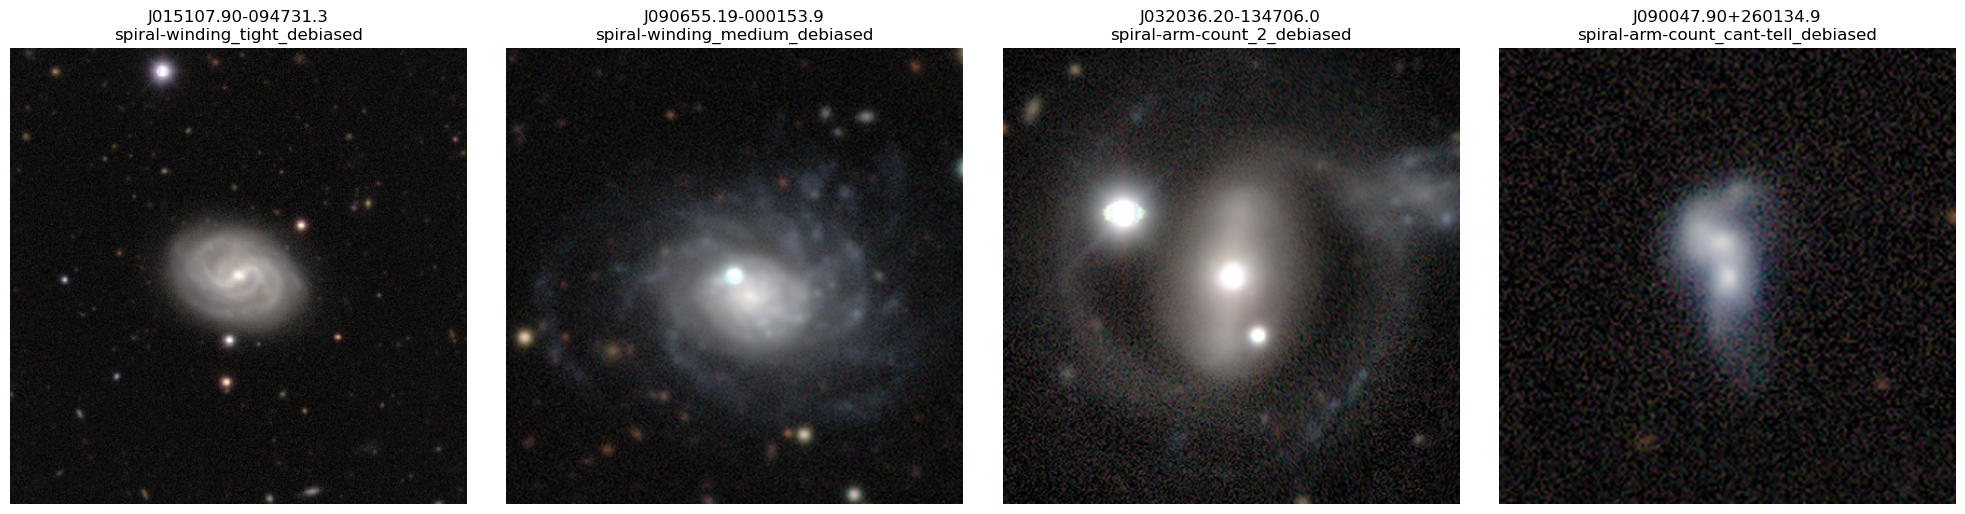

In [177]:
names = ['J015107.90-094731.3', 'J090655.19-000153.9', 'J032036.20-134706.0', 'J090047.90+260134.9']
class_of_names = ['spiral-winding_tight_debiased', 'spiral-winding_medium_debiased', 'spiral-arm-count_2_debiased', 'spiral-arm-count_cant-tell_debiased']

# Getting the images for the three objects
def get_image_by_name(df_val, name):
    image_path = df_val[df_val['iauname'] == name]['image_path'].values[0]
    return Image.open(image_path)

# Checking the dimensions and type of the images
def check_image_dimensions_and_type(image):
    print(f"Image size: {image.size}, Type: {type(image)}")

check_image_dimensions_and_type(get_image_by_name(df_val, names[0]))

fig, axes = plt.subplots(1, 4, figsize=(20, 5))

for ax, name, class_name in zip(axes, names, class_of_names):
    galaxy_df = df_val[df_val['iauname'] == name]
    if galaxy_df.empty:
        print(f"No data found for galaxy {name}")
        ax.axis('off')
        continue

    image_path = galaxy_df['image_path'].values[0]
    img = Image.open(image_path).convert('RGB')

    ax.imshow(img)
    ax.set_title(f"{name}\n{class_name}", fontsize=12)
    ax.axis('off')

plt.tight_layout()
plt.show()

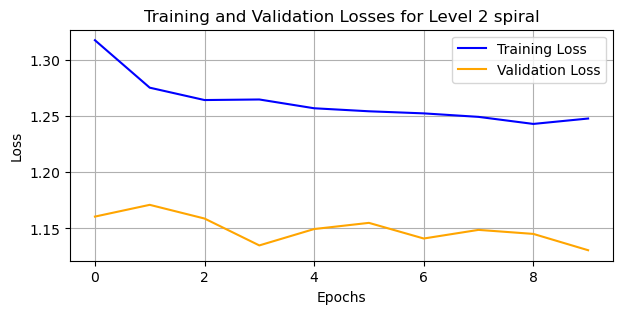

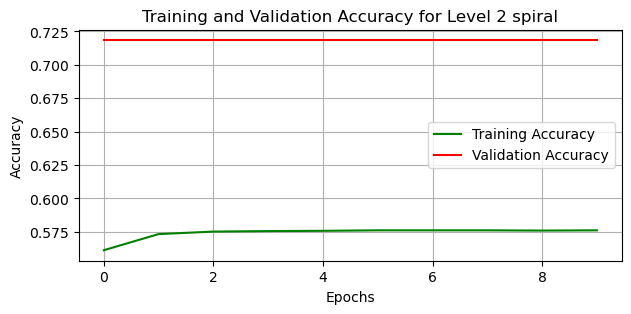

In [178]:
plot_losses(train_losses_spiral, val_losses_spiral, title = 'Training and Validation Losses for Level 2 spiral')
plot_accuracies(train_accuracies_spiral, val_accuracies_spiral, title = 'Training and Validation Accuracy for Level 2 spiral')

### ---- FINAL LEVEL ----

In [179]:
val_level_merging = GalaxyBranchDataset.GalaxyBranchDataset(
    df_val, final_labels, transform = val_transform, image_col = 'image_path'
)
dataloader_val_merging = create_dataloader(val_level_merging, batch_size = 32, shuffle = False)

In [180]:
num_epochs = 10
device = 'cpu'

# Train spiral branch
model_final, metrics_final = train_model(
    model_merging,
    dataloader_merging,
    dataloader_val_merging,
    num_epochs = num_epochs,
    lr = 1e-4,
    device = device
)

train_losses_final = metrics_final['train_losses']
val_losses_final = metrics_final['val_losses']
train_accuracies_final = metrics_final['train_accuracies']
val_accuracies_final = metrics_final['val_accuracies']

Epoch 1/10: 100%|██████████| 166/166 [01:23<00:00,  1.98it/s]


Epoch 1: Train Loss = 0.7810, Train Acc = 0.7843 | Val Loss = 0.6822, Val Acc = 0.8217


Epoch 2/10: 100%|██████████| 166/166 [01:23<00:00,  1.99it/s]


Epoch 2: Train Loss = 0.7603, Train Acc = 0.7864 | Val Loss = 0.6787, Val Acc = 0.8217


Epoch 3/10: 100%|██████████| 166/166 [01:23<00:00,  1.99it/s]


Epoch 3: Train Loss = 0.7606, Train Acc = 0.7864 | Val Loss = 0.6763, Val Acc = 0.8217


Epoch 4/10: 100%|██████████| 166/166 [01:23<00:00,  1.99it/s]


Epoch 4: Train Loss = 0.7552, Train Acc = 0.7864 | Val Loss = 0.6873, Val Acc = 0.8217


Epoch 5/10: 100%|██████████| 166/166 [01:23<00:00,  1.99it/s]


Epoch 5: Train Loss = 0.7590, Train Acc = 0.7864 | Val Loss = 0.6746, Val Acc = 0.8217


Epoch 6/10: 100%|██████████| 166/166 [01:23<00:00,  1.99it/s]


Epoch 6: Train Loss = 0.7569, Train Acc = 0.7864 | Val Loss = 0.6894, Val Acc = 0.8217


Epoch 7/10: 100%|██████████| 166/166 [01:23<00:00,  1.98it/s]


Epoch 7: Train Loss = 0.7566, Train Acc = 0.7864 | Val Loss = 0.6746, Val Acc = 0.8217


Epoch 8/10: 100%|██████████| 166/166 [01:25<00:00,  1.94it/s]


Epoch 8: Train Loss = 0.7569, Train Acc = 0.7864 | Val Loss = 0.7124, Val Acc = 0.8217


Epoch 9/10: 100%|██████████| 166/166 [01:23<00:00,  1.98it/s]


Epoch 9: Train Loss = 0.7512, Train Acc = 0.7864 | Val Loss = 0.6690, Val Acc = 0.8217


Epoch 10/10: 100%|██████████| 166/166 [01:25<00:00,  1.93it/s]


Epoch 10: Train Loss = 0.7559, Train Acc = 0.7864 | Val Loss = 0.6749, Val Acc = 0.8217


In [181]:
probs_merging, preds_merging, targets_merging = evaluate_multiclass_model(
    model_merging,
    dataloader_val_merging,
    label_names = final_labels,
    device = device
)

Classification Report:
                                    precision    recall  f1-score   support

             merging_none_debiased       0.82      1.00      0.90      3088
merging_minor-disturbance_debiased       0.00      0.00      0.00       270
merging_major-disturbance_debiased       0.00      0.00      0.00       174
           merging_merger_debiased       0.00      0.00      0.00       226

                          accuracy                           0.82      3758
                         macro avg       0.21      0.25      0.23      3758
                      weighted avg       0.68      0.82      0.74      3758

Confusion Matrix:
[[3088    0    0    0]
 [ 270    0    0    0]
 [ 174    0    0    0]
 [ 226    0    0    0]]


/Applications/anaconda3/envs/MachineLearning/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Applications/anaconda3/envs/MachineLearning/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Applications/anaconda3/envs/MachineLearning/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

In [182]:
print_confident_galaxies_per_true_label(
    df_val = df_val,
    probs = probs_merging,
    targets = targets_merging,
    class_names = final_labels,
    conf_threshold = 0.1
)

Class 'merging_none_debiased':
  Galaxy: J082553.48+043505.7, Confidence: 0.8096

Class 'merging_minor-disturbance_debiased':
  Galaxy: J075207.41+232928.3, Confidence: 0.1155

Class 'merging_major-disturbance_debiased':
  Galaxy: J023801.95+001924.5, Confidence: 0.1324

No samples with confidence > 0.1 for class 'merging_merger_debiased'.


Image size: (424, 424), Type: <class 'PIL.PngImagePlugin.PngImageFile'>


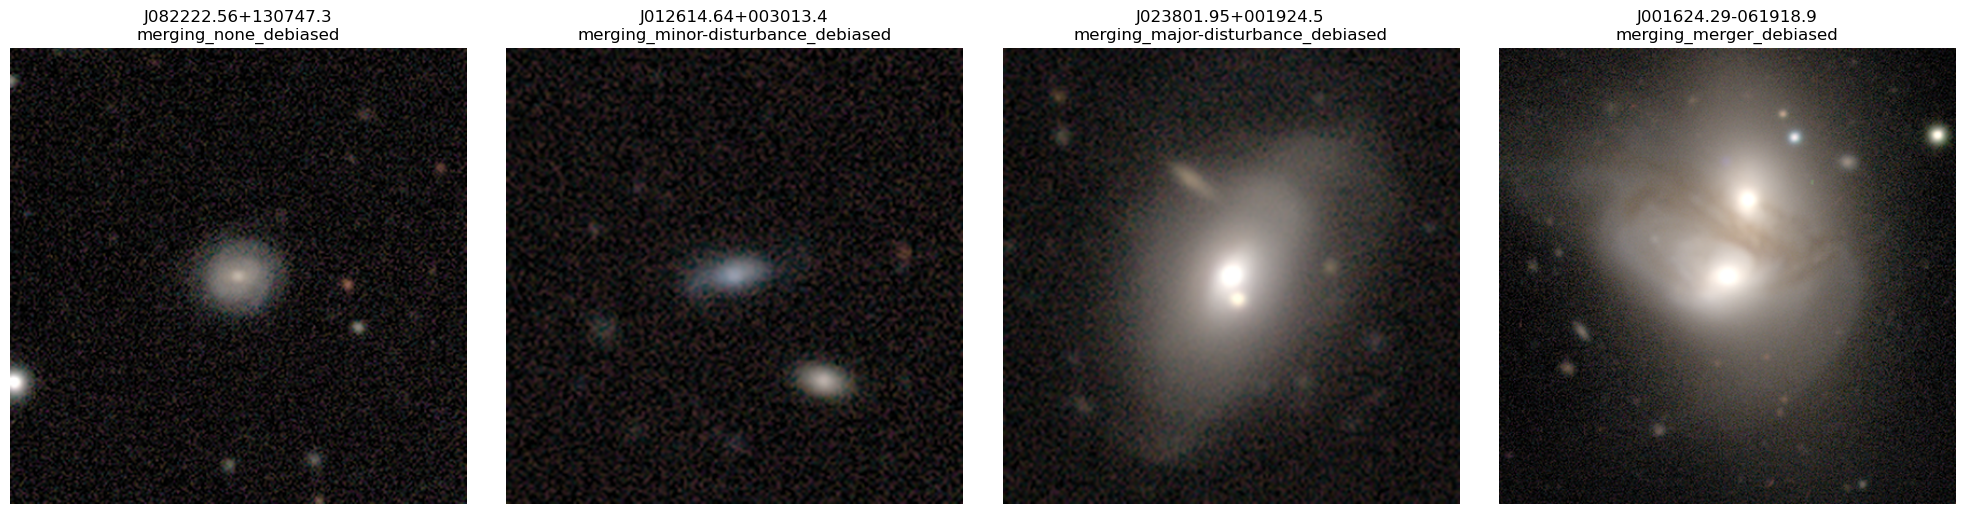

In [183]:
names = ['J082222.56+130747.3', 'J012614.64+003013.4', 'J023801.95+001924.5', 'J001624.29-061918.9']
class_of_names = ['merging_none_debiased', 'merging_minor-disturbance_debiased', 'merging_major-disturbance_debiased', 'merging_merger_debiased']

# Getting the images for the three objects
def get_image_by_name(df_val, name):
    image_path = df_val[df_val['iauname'] == name]['image_path'].values[0]
    return Image.open(image_path)

# Checking the dimensions and type of the images
def check_image_dimensions_and_type(image):
    print(f"Image size: {image.size}, Type: {type(image)}")

check_image_dimensions_and_type(get_image_by_name(df_val, names[0]))

fig, axes = plt.subplots(1, 4, figsize=(20, 5))

for ax, name, class_name in zip(axes, names, class_of_names):
    galaxy_df = df_val[df_val['iauname'] == name]
    if galaxy_df.empty:
        print(f"No data found for galaxy {name}")
        ax.axis('off')
        continue

    image_path = galaxy_df['image_path'].values[0]
    img = Image.open(image_path).convert('RGB')

    ax.imshow(img)
    ax.set_title(f"{name}\n{class_name}", fontsize=12)
    ax.axis('off')

plt.tight_layout()
plt.show()

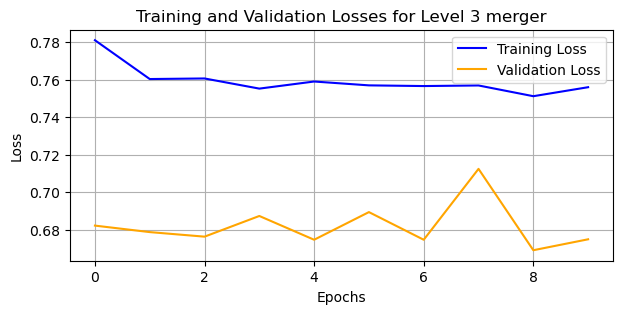

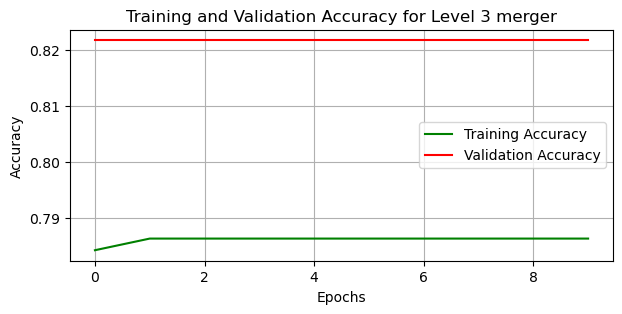

In [184]:
plot_losses(train_losses_final, val_losses_final, title = 'Training and Validation Losses for Level 3 merger')
plot_accuracies(train_accuracies_final, val_accuracies_final, title = 'Training and Validation Accuracy for Level 3 merger')

##### Saving all of the models, train losses and validation losses

In [185]:
# Saving all of the models 
save_path = '/Users/ChamillaTerp/Dropbox/Skole/Master/Applied Machine Learning/AML2025_FinalProject/Chamilla/models_2'

def save_model(model, model_name, save_path):
    model_save_path = os.path.join(save_path, model_name)
    torch.save(model.state_dict(), model_save_path)
    print(f"Model saved to {model_save_path}")

save_model(model_level_0, 'model_level_0_v2.pth', save_path)
save_model(model_smooth, 'model_smooth_v2.pth', save_path)
save_model(model_disk, 'model_disk_v2.pth', save_path)
save_model(model_spiral, 'model_spiral_v2.pth', save_path)
save_model(model_merging, 'model_merging_v2.pth', save_path)

# Saving the training and validation losses
def save_losses(losses, model_name, save_path):
    losses_save_path = os.path.join(save_path, f"{model_name}_losses_v2.json")
    with open(losses_save_path, 'w') as f:
        json.dump(losses, f)
    print(f"Losses saved to {losses_save_path}")

save_losses({
    'train': train_losses_level_0,
    'val': val_losses_level_0
}, 'model_level_0_v2', save_path)

save_losses({
    'train': train_losses_smooth,
    'val': val_losses_smooth
}, 'model_smooth_v2', save_path)

save_losses({
    'train': train_losses_disk,
    'val': val_losses_disk
}, 'model_disk_v2', save_path)

save_losses({
    'train': train_losses_spiral,
    'val': val_losses_spiral
}, 'model_spiral_v2', save_path)

save_losses({
    'train': train_losses_final,
    'val': val_losses_final
}, 'model_merging_v2', save_path)

Model saved to /Users/ChamillaTerp/Dropbox/Skole/Master/Applied Machine Learning/AML2025_FinalProject/Chamilla/models_2/model_level_0_v2.pth
Model saved to /Users/ChamillaTerp/Dropbox/Skole/Master/Applied Machine Learning/AML2025_FinalProject/Chamilla/models_2/model_smooth_v2.pth
Model saved to /Users/ChamillaTerp/Dropbox/Skole/Master/Applied Machine Learning/AML2025_FinalProject/Chamilla/models_2/model_disk_v2.pth
Model saved to /Users/ChamillaTerp/Dropbox/Skole/Master/Applied Machine Learning/AML2025_FinalProject/Chamilla/models_2/model_spiral_v2.pth
Model saved to /Users/ChamillaTerp/Dropbox/Skole/Master/Applied Machine Learning/AML2025_FinalProject/Chamilla/models_2/model_merging_v2.pth
Losses saved to /Users/ChamillaTerp/Dropbox/Skole/Master/Applied Machine Learning/AML2025_FinalProject/Chamilla/models_2/model_level_0_v2_losses_v2.json
Losses saved to /Users/ChamillaTerp/Dropbox/Skole/Master/Applied Machine Learning/AML2025_FinalProject/Chamilla/models_2/model_smooth_v2_losses_v2.

## Using the models 

In [186]:
device = 'cpu'

# Recreate models (make sure num_outputs match your saved models)
model_level_0 = SimpleCNN(num_outputs = len(level_0_labels))
model_smooth = SimpleCNN(num_outputs = len(level_1_smooth_labels))
model_disk = SimpleCNN(num_outputs = len(level_1_disk_labels))
model_spiral = SimpleCNN(num_outputs = len(level_2_spiral_labels))
model_merging = SimpleCNN(num_outputs = len(final_labels))

# Define the path where models are saved
save_path = '/Users/ChamillaTerp/Dropbox/Skole/Master/Applied Machine Learning/AML2025_FinalProject/Chamilla/models_2'

# Load state dicts
model_level_0.load_state_dict(torch.load(os.path.join(save_path, 'model_level_0_v2.pth'), map_location = device))
model_smooth.load_state_dict(torch.load(os.path.join(save_path, 'model_smooth_v2.pth'), map_location = device))
model_disk.load_state_dict(torch.load(os.path.join(save_path, 'model_disk_v2.pth'), map_location = device))
model_spiral.load_state_dict(torch.load(os.path.join(save_path, 'model_spiral_v2.pth'), map_location = device))
model_merging.load_state_dict(torch.load(os.path.join(save_path, 'model_merging_v2.pth'), map_location = device))

# Move to device and set eval mode
model_level_0.to(device).eval()
model_smooth.to(device).eval()
model_disk.to(device).eval()
model_spiral.to(device).eval()
model_merging.to(device).eval();


In [187]:
# Validation set 
val_dataset = GalaxyBranchDataset.GalaxyBranchDataset(
    df_val,
    level_0_labels,   # Use level 0 labels here — since your dataloader returns images and labels; labels won’t be used in inference, but needed for dataset init
    transform = val_transform,
    image_col = 'image_path'
)

val_dataloader = create_dataloader(val_dataset, batch_size = 32, shuffle = False)

In [188]:
def hierarchical_predict_gz_campaign5(
    model_level_0,
    model_smooth,
    model_disk,
    model_spiral,
    model_merging,
    dataloader,
    device='cpu',
    conf_threshold=0.5
):
    results = []

    with torch.no_grad():
        for images, _labels in tqdm(dataloader):
            images = images.to(device)

            # Level 0 prediction
            outputs_0 = model_level_0(images)
            probs_0 = torch.sigmoid(outputs_0)
            preds_0 = probs_0.argmax(dim=1)

            for i, pred_0 in enumerate(preds_0):
                img = images[i].unsqueeze(0)
                output = {'level_0': {}, 'level_1': {}, 'level_2': None}

                # Level 0 results
                probs_0_np = probs_0[i].cpu().numpy()
                output['level_0']['pred_idx'] = pred_0.item()
                output['level_0']['pred_label'] = level_0_labels[pred_0.item()]
                output['level_0']['probs'] = probs_0_np

                if pred_0 == 0:  # Smooth branch
                    # Level 1 smooth (how rounded)
                    outputs_1 = model_smooth(img)
                    probs_1 = torch.sigmoid(outputs_1).cpu().numpy()[0]
                    pred_1_idx = int(np.argmax(probs_1))
                    output['level_1']['branch'] = 'smooth'
                    output['level_1']['pred_idx'] = pred_1_idx
                    output['level_1']['pred_label'] = level_1_smooth_labels[pred_1_idx]
                    output['level_1']['probs'] = probs_1

                    # No further levels for smooth
                    output['level_2'] = None

                elif pred_0 == 1:  # Featured or Disk branch
                    # Level 1 disk (multiple labels)
                    outputs_1 = model_disk(img)
                    probs_1 = torch.sigmoid(outputs_1).cpu().numpy()[0]
                    pred_1_idx = int(np.argmax(probs_1))
                    output['level_1']['branch'] = 'disk'
                    output['level_1']['pred_idx'] = pred_1_idx
                    output['level_1']['pred_label'] = level_1_disk_labels[pred_1_idx]
                    output['level_1']['probs'] = probs_1

                    # Check if spiral arms present for level 2 decision
                    spiral_arm_yes_idx = level_1_disk_labels.index('has-spiral-arms_yes_debiased')

                    if probs_1[spiral_arm_yes_idx] > conf_threshold:
                        # Run level 2 spiral models
                        outputs_2 = model_spiral(img)
                        probs_2 = torch.sigmoid(outputs_2).cpu().numpy()[0]
                        pred_2_idx = int(np.argmax(probs_2))
                        output['level_2'] = {
                            'branch': 'spiral',
                            'pred_idx': pred_2_idx,
                            'pred_label': level_2_spiral_labels[pred_2_idx],
                            'probs': probs_2
                        }
                    else:
                        # Run level 2 merging model
                        outputs_2 = model_merging(img)
                        probs_2 = torch.sigmoid(outputs_2).cpu().numpy()[0]
                        pred_2_idx = int(np.argmax(probs_2))
                        output['level_2'] = {
                            'branch': 'merging',
                            'pred_idx': pred_2_idx,
                            'pred_label': final_labels[pred_2_idx],
                            'probs': probs_2
                        }

                else:
                    # Star or artifact branch — end here
                    output['level_1'] = None
                    output['level_2'] = None

                results.append(output)

    return results

In [189]:
results = hierarchical_predict_gz_campaign5(
    model_level_0,
    model_smooth,
    model_disk,
    model_spiral,
    model_merging,
    val_dataloader,
    device=device,
    conf_threshold = 0.3  # The threshold can be adjusted 
)

100%|██████████| 118/118 [01:07<00:00,  1.74it/s]


In [190]:
def print_hierarchical_results_top1_with_images_random(results, dataframe, top_n = 5):
    total_samples = len(results)
    random_indices = random.sample(range(total_samples), min(top_n, total_samples))
    
    for i, idx in enumerate(random_indices):
        r = results[idx]
        print(f"Sample {i} (dataset index {idx}):")

        # Load and show image
        img_path = dataframe.iloc[idx]['image_path']
        img = Image.open(img_path).convert('RGB')
        plt.imshow(img)
        plt.axis('off')
        plt.title(f"Sample {i} Image (index {idx})")
        plt.show()

        # Level 0
        print(f"  Level 0 prediction: {r['level_0']['pred_label']}")
        print(f"  Level 0 probabilities:")
        for idx_prob, prob in enumerate(r['level_0']['probs']):
            print(f"    {level_0_labels[idx_prob]}: {prob:.3f}")

        # Level 1
        l1 = r.get('level_1')
        if l1 is not None:
            branch_labels = None
            if l1['branch'] == 'smooth':
                branch_labels = level_1_smooth_labels
            elif l1['branch'] == 'disk':
                branch_labels = level_1_disk_labels

            pred_idx = l1.get('pred_idx')
            pred_label = branch_labels[pred_idx] if branch_labels and pred_idx is not None else 'N/A'
            print(f"  Level 1 branch: {l1['branch']}")
            print(f"  Level 1 top predicted class: {pred_label} (index {pred_idx})")
            print(f"  Level 1 probability: {l1['probs'][pred_idx]:.3f}" if pred_idx is not None else "  No prediction")

        # Level 2
        l2 = r.get('level_2')
        if l2 is not None:
            branch_labels = None
            if l2['branch'] == 'spiral':
                branch_labels = level_2_spiral_labels
            elif l2['branch'] == 'merging':
                branch_labels = final_labels

            pred_idx = l2.get('pred_idx')
            pred_label = branch_labels[pred_idx] if branch_labels and pred_idx is not None else 'N/A'
            print(f"  Level 2 branch: {l2['branch']}")
            print(f"  Level 2 top predicted class: {pred_label} (index {pred_idx})")
            print(f"  Level 2 probability: {l2['probs'][pred_idx]:.3f}" if pred_idx is not None else "  No prediction")

        print('-' * 50)

Sample 0 (dataset index 311):


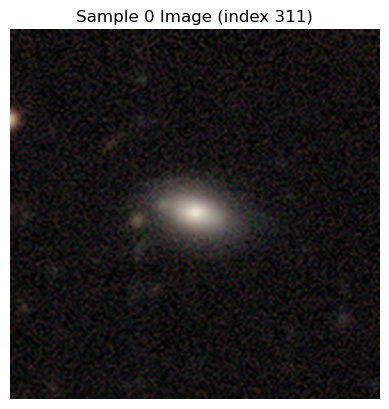

  Level 0 prediction: smooth-or-featured_featured-or-disk_debiased
  Level 0 probabilities:
    smooth-or-featured_smooth_debiased: 0.567
    smooth-or-featured_featured-or-disk_debiased: 0.860
    smooth-or-featured_artifact_debiased: 0.004
  Level 1 branch: disk
  Level 1 top predicted class: disk-edge-on_no_debiased (index 1)
  Level 1 probability: 0.970
  Level 2 branch: spiral
  Level 2 top predicted class: spiral-winding_tight_debiased (index 0)
  Level 2 probability: 0.952
--------------------------------------------------


In [191]:
print_hierarchical_results_top1_with_images_random(results, df_val, top_n = 1)

### New try

In [192]:
def hierarchical_predict_gz_campaign5_argmax(
    model_level_0,
    model_smooth,
    model_disk,
    model_spiral,
    model_merging,
    dataloader,
    device='cpu'
):
    results = []

    with torch.no_grad():
        for images, _labels in tqdm(dataloader):
            images = images.to(device)

            # Level 0 prediction
            outputs_0 = model_level_0(images)
            probs_0 = torch.sigmoid(outputs_0)
            preds_0 = probs_0.argmax(dim=1)

            for i, pred_0 in enumerate(preds_0):
                img = images[i].unsqueeze(0)
                output = {'level_0': {}, 'level_1': {}, 'level_2': None}

                # Level 0 results
                probs_0_np = probs_0[i].cpu().numpy()
                output['level_0']['pred_idx'] = pred_0.item()
                output['level_0']['pred_label'] = level_0_labels[pred_0.item()]
                output['level_0']['probs'] = probs_0_np

                if pred_0 == 0:  # Smooth branch
                    # Level 1 smooth (how rounded)
                    outputs_1 = model_smooth(img)
                    probs_1 = torch.sigmoid(outputs_1).cpu().numpy()[0]
                    pred_1_idx = int(np.argmax(probs_1))
                    output['level_1']['branch'] = 'smooth'
                    output['level_1']['pred_idx'] = pred_1_idx
                    output['level_1']['pred_label'] = level_1_smooth_labels[pred_1_idx]
                    output['level_1']['probs'] = probs_1

                    # No further levels for smooth
                    output['level_2'] = None

                elif pred_0 == 1:  # Featured or Disk branch
                    # Level 1 disk (multi-label but here treat as multi-class by argmax)
                    outputs_1 = model_disk(img)
                    probs_1 = torch.sigmoid(outputs_1).cpu().numpy()[0]
                    pred_1_idx = int(np.argmax(probs_1))
                    output['level_1']['branch'] = 'disk'
                    output['level_1']['pred_idx'] = pred_1_idx
                    output['level_1']['pred_label'] = level_1_disk_labels[pred_1_idx]
                    output['level_1']['probs'] = probs_1

                    # Use argmax disk prediction to decide level 2 branch
                    top_label = level_1_disk_labels[pred_1_idx]

                    #print(f"Disk branch top predicted label: {top_label}")  # Debug print

                    if top_label == 'has-spiral-arms_yes_debiased':
                        # Run spiral level 2
                        outputs_2 = model_spiral(img)
                        probs_2 = torch.sigmoid(outputs_2).cpu().numpy()[0]
                        pred_2_idx = int(np.argmax(probs_2))
                        output['level_2'] = {
                            'branch': 'spiral',
                            'pred_idx': pred_2_idx,
                            'pred_label': level_2_spiral_labels[pred_2_idx],
                            'probs': probs_2
                        }
                    else:
                        # Run merging level 2
                        outputs_2 = model_merging(img)
                        probs_2 = torch.sigmoid(outputs_2).cpu().numpy()[0]
                        pred_2_idx = int(np.argmax(probs_2))
                        output['level_2'] = {
                            'branch': 'merging',
                            'pred_idx': pred_2_idx,
                            'pred_label': final_labels[pred_2_idx],
                            'probs': probs_2
                        }

                else:
                    # Star or artifact branch — no further levels
                    output['level_1'] = None
                    output['level_2'] = None

                results.append(output)

    return results

In [193]:
results = hierarchical_predict_gz_campaign5_argmax(
    model_level_0,
    model_smooth,
    model_disk,
    model_spiral,
    model_merging,
    val_dataloader,
    device = device
)

100%|██████████| 118/118 [01:08<00:00,  1.73it/s]


Sample 0 (dataset index 3083):


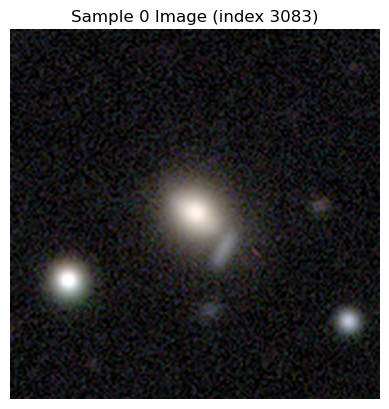

  Level 0 prediction: smooth-or-featured_featured-or-disk_debiased
  Level 0 probabilities:
    smooth-or-featured_smooth_debiased: 0.657
    smooth-or-featured_featured-or-disk_debiased: 0.763
    smooth-or-featured_artifact_debiased: 0.011
  Level 1 branch: disk
  Level 1 top predicted class: disk-edge-on_no_debiased (index 1)
  Level 1 probability: 0.971
  Level 2 branch: merging
  Level 2 top predicted class: merging_none_debiased (index 0)
  Level 2 probability: 0.870
--------------------------------------------------


In [194]:
print_hierarchical_results_top1_with_images_random(results, df_val, top_n = 1)

In [195]:
def prepare_image_for_plotting(image_tensor):
    """
    Unnormalizes and prepares an image tensor (C x H x W) for matplotlib display.
    Assumes normalization with mean=0.5 and std=0.5 for each channel (i.e., x_norm = (x - 0.5) / 0.5).
    """
    # Unnormalize
    img = image_tensor * 0.5 + 0.5  # Inverse of (x - 0.5) / 0.5
    img = torch.clamp(img, 0, 1)   # Ensure values are in [0, 1]
    return img.permute(1, 2, 0).cpu().numpy()  # CxHxW -> HxWxC

In [198]:
def plot_galaxies_from_dataset_with_predictions(names, results, dataset, dataframe):
    n = len(names)
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))  # 2 rows x 2 columns, size adjusted
    axes = axes.flatten()

    for i, name in enumerate(names):
        # Find index of galaxy in dataframe
        idx_list = dataframe.index[dataframe['iauname'] == name].tolist()
        if not idx_list:
            print(f"Galaxy {name} not found in dataframe.")
            axes[i].axis('off')
            continue
        idx = idx_list[0]

        # Get image tensor from dataset and prepare for plotting
        img_tensor, _ = dataset[idx]
        img = prepare_image_for_plotting(img_tensor)

        ax = axes[i]
        ax.imshow(img)
        ax.axis('off')
        ax.set_title(name, fontsize = 10)

        # Get prediction results for this galaxy
        r = results[idx]
        pred_text = f"Level 0: {r['level_0']['pred_label']}, Conf.: {r['level_0']['probs'][r['level_0']['pred_idx']]:.2f}\n"

        l1 = r.get('level_1')
        if l1 is not None:
            pred_text += f"Level 1 ({l1['branch']}): {l1['pred_label']}, Conf.: {l1['probs'][l1['pred_idx']]:.2f}\n"
        else:
            pred_text += "Level 1: None\n"

        l2 = r.get('level_2')
        if l2 is not None:
            pred_text += f"Level 2 ({l2['branch']}): {l2['pred_label']}, Conf.: {l2['probs'][l2['pred_idx']]:.2f}"
        else:
            pred_text += "Level 2: None"

        ax.text(
            0.5, -0.15, pred_text,
            fontsize=9,
            ha='center',
            va='top',
            transform=ax.transAxes,
            wrap=True
        )

    plt.tight_layout()

    # Saving the plots 
    save_path = '/Users/ChamillaTerp/Dropbox/Skole/Master/Applied Machine Learning/AML2025_FinalProject/Chamilla/plots'
    plt.savefig(os.path.join(save_path, 'galaxies_with_predictions.png'), bbox_inches='tight', dpi=300)

    plt.show()

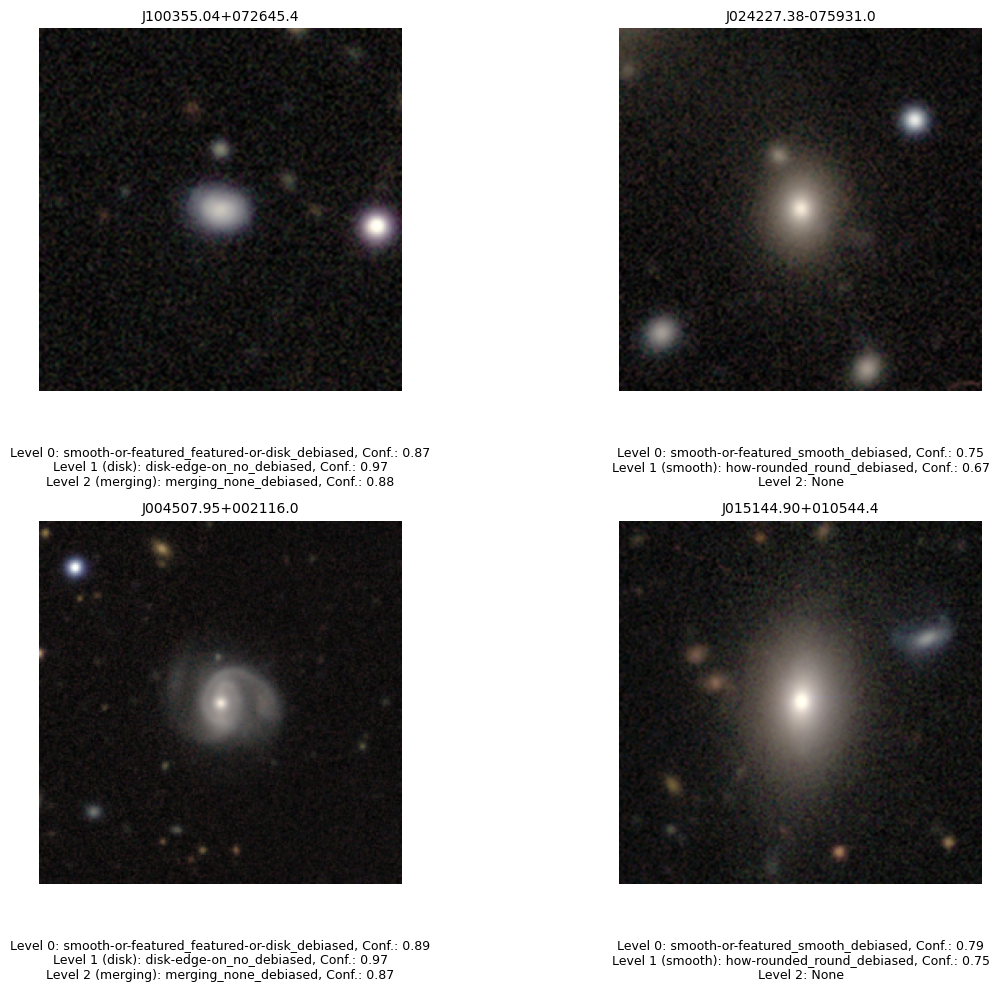

In [199]:
galaxy_names = [
    'J100355.04+072645.4',
    'J024227.38-075931.0',
    'J004507.95+002116.0',
    'J015144.90+010544.4'
]

plot_galaxies_from_dataset_with_predictions(galaxy_names, results, val_dataset, df_val)

In [ ]:
import os
import json
import matplotlib.pyplot as plt

# Path where models and loss histories are saved
save_path = '/Users/ChamillaTerp/Dropbox/Skole/Master/Applied Machine Learning/AML2025_FinalProject/Chamilla/models_2'

# Model names
model_names = ['model_level_0', 'model_smooth', 'model_disk', 'model_spiral', 'model_merging']

# Dictionary to hold all validation losses
val_losses = {}

# Load each model's validation loss
for name in model_names:
    loss_file = os.path.join(save_path, f"{name}_losses.json")
    with open(loss_file, 'r') as f:
        losses = json.load(f)
        val_losses[name] = losses['val']

# Plotting validation accuracy (assuming accuracy ≈ 1 - val_loss)
plt.figure(figsize=(10, 6))
for name, losses in val_losses.items():
    accuracy = [1 - float(loss) for loss in losses]  # assuming loss is like cross-entropy
    plt.plot(accuracy, label=name)

plt.title('Validation Accuracy per Model')
plt.xlabel('Epoch')
plt.ylabel('Validation Accuracy')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
